In [39]:
import pandas as pd # dataframes and csv
import numpy as np # linear algebra
import sklearn as sk # data maniputation
import matplotlib.pyplot as plt # data visualization
import re # regular expressions for the text
import tensorflow as tf # for ML


from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from transformers import BertTokenizer
from tokenizers import SentencePieceBPETokenizer
#from tensorflow_text.tools.wordpiece_vocab import bert_vocab_from_dataset as bert_vocab

                                                  text sentiment
0    Hi Leah, I ordered this early to give to a co-...  Positive
1    Good evening, \n  I just received my order! I ...  Positive
2    I couldn’t find where I could write a review b...  Positive
3    I received my order today and gave it to my si...  Positive
4    ﻿Max,\n\nWe received the heart but sadly are d...  Negative
..                                                 ...       ...
249    Thank you, this is beautiful and they loved it.  Positive
250                    Thanks so much. They lookgreat!  Positive
251  Emily, \n  THANK YOU so much for the new “bric...  Positive
252  Jacqueline,  \n  I just received the replaceme...  Positive
253  Order #(857)982-509708\nI just received my ord...  Positive

[254 rows x 2 columns]


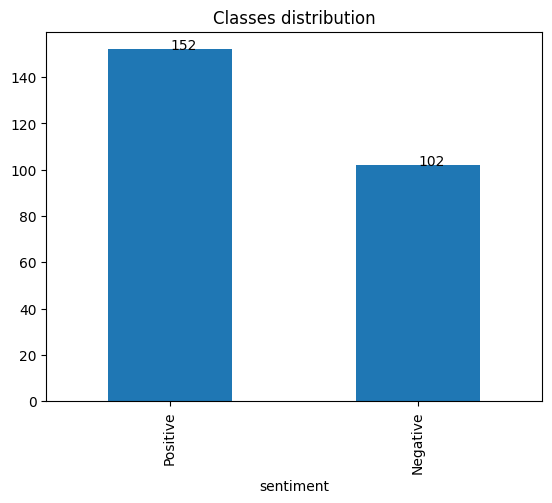

In [40]:
#downloading data
labels = pd.read_csv("./data/labels.csv")
reviews = pd.read_csv("./data/reviews.csv")

#making it more generalized(easy to work with)
reviews = reviews.merge(labels,"outer","id")
dataset = reviews.drop(labels = "id",axis=1)
print(dataset)

dataset["sentiment"].value_counts().plot(kind='bar', title='Classes distribution')
count_positive = len([i for i in dataset["sentiment"] if i=="Positive"])
count_negative = len([i for i in dataset["sentiment"] if i=="Negative"])
plt.text(0,count_positive,str(count_positive))
plt.text(1,count_negative,str(count_negative))
plt.show()

Negative to Positive ratio is okay. No need to fix training and testing datasets manualy

In [41]:
#Finding the vocab size
words = []
max_length = []

for i in dataset["text"]:
    i = re.split(r'[,\s!?()._\-]+', i)
    i = [j for j in i if j is not None and j!=""]
    max_length.append(len(i))
    for j in i:

        words.append(j)
words = list(set(words))
max_length_num=max(max_length)
print(max(max_length))
print(dataset["text"][max_length.index(max(max_length))])
print(len(words))
print("AVG LENGTH: " + str(np.array([len(i) for i in dataset["text"]]).mean()))

266
Mr. Lans, 
  Thank you for this email and the opportunity to let you know about the finished product that I received yesterday. My husband Christopher, helped me order this item gift for a good friend who lost her daughter Kimberly. I’ve ordered these 3D products before with wonderful results, but I’m wondering now if maybe it was from a different company because I must tell you I was VERY disappointed with the end result of this one. It’s very hard to see exactly what the finished product is going to look like on a computer screen, so thought choosing the heart design would work. But it didn’t at all. The bottom of the heart looks like it’s making a “dent” in the top of Kimberly’s head. So there is no way I could possibility send this to my friend. I think your system should be able to advise you if the image submitted would not be a good fit and allow you to either choose a different item or perhaps suggest you selected a larger size heart. If given the choice, (for only $20 more

The data is generalized and explored. Splitted correctly. No need of punctuation

Splitting training and testing data. Replace "Positive" and "Negative" with 1 and 0

In [42]:
train, test = train_test_split(dataset, test_size=0.2, random_state=42, shuffle=True)

training_sentences = []
training_labels = []

testing_sentences = []
testing_labels = []

# Loop over all training examples and save the sentences and labels
for t in train["text"]:
  training_sentences.append(t)

for s in train["sentiment"]:
  if s == "Positive": # Redo the labels so the processing is faster 
    training_labels.append(1)
  else:
    training_labels.append(0)

# Loop over all test examples and save the sentences and labels
for t in test["text"]:
  testing_sentences.append(t)

for s in test["sentiment"]:
  if s == "Positive": # Redo the labels so the processing is faster 
    testing_labels.append(1)
  else:
    testing_labels.append(0)

# Convert labels lists to numpy array
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)



Tokenizing and adding to separate list

In [43]:
sentences = []
pattern = r'[,\s!?()._\-]+'
for sentence in dataset["text"]:
    sentence = sentence.lower()
    sentence = re.split(pattern, sentence) # Split the text based on the pattern
    sentence = " ".join(sentence)
    sentences.append(sentence)

BERT Tokenizer (tried to use and I decided not to choose this one)

In [150]:
tokenizer_bert = BertTokenizer.from_pretrained("bert-base-uncased")
tokenized_sentences = tokenizer_bert(sentences,padding=True, truncation='only_first', return_tensors="tf")
print(tokenized_sentences)

{'input_ids': <tf.Tensor: shape=(254, 299), dtype=int32, numpy=
array([[  101,  7632, 14188, ...,     0,     0,     0],
       [  101,  2204,  3944, ...,     0,     0,     0],
       [  101,  1045,  2481, ...,     0,     0,     0],
       ...,
       [  101,  6253,  4067, ...,     0,     0,     0],
       [  101, 17551,  1045, ...,     0,     0,     0],
       [  101,  2344,  1001, ...,     0,     0,     0]])>, 'token_type_ids': <tf.Tensor: shape=(254, 299), dtype=int32, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])>, 'attention_mask': <tf.Tensor: shape=(254, 299), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])>}


SentencePieceBPETokenizer. This one is used in tokenizing the sentences

In [155]:
with open("text.txt", "w", encoding="utf-8") as f:
    for sentence in sentences:
        f.write(sentence+"\n")
    f.close()

vocab_size = 10000
trunc_type='pre'
oov_tok = "<OOV>"

BPE_sentence_tokenizer = SentencePieceBPETokenizer()
BPE_sentence_tokenizer.train("text.txt",vocab_size=vocab_size)

encoded_texts = [BPE_sentence_tokenizer.encode(text).ids for text in sentences]
# Pad the sequences to a consistent length
X = pad_sequences(encoded_texts, maxlen=max_length_num, padding='pre')
print(X)
label_mapping = {"Positive": 1, "Negative": 0}
encoded_labels = [label_mapping[label] for label in dataset["sentiment"]]
y = np.array(encoded_labels)

# Split your data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

word_to_find = "disappointed"
# Encode the word to get its ID
encoded_word = BPE_sentence_tokenizer.encode(word_to_find)
word_id = encoded_word.ids[0]
print(word_id)

[[   0    0    0 ...  156  852  180]
 [   0    0    0 ...  355  134  287]
 [   0    0    0 ...  186  127  724]
 ...
 [   0    0    0 ...  186  127  724]
 [   0    0    0 ...  814  443   80]
 [   0    0    0 ...  119 1146 1841]]
246


TF tokenizer. (used before the idea about subwords)

In [77]:
# Parameters

# Initialize the Tokenizer class
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)

# Generate the word index dictionary for the training sentences
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index
print(f'number of words in word_index: {len(word_index)}')


# Generate and pad the training sequences
sequences = tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences, truncating=trunc_type)
print(padded)

# Generate and pad the test sequences
testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences)
print(training_labels_final)

number of words in word_index: 1898
[[  0   0   0 ...  43  14   8]
 [  0   0   0 ...   4 202 792]
 [  0   0   0 ... 799 182  94]
 ...
 [  0   0   0 ...  24   7  50]
 [  0   0   0 ... 153   1   1]
 [  0   0   0 ...   3 114   1]]
[1 1 1 1 1 0 0 1 0 1 1 0 0 1 0 1 1 0 1 1 0 0 1 0 1 1 1 1 1 1 1 0 1 0 0 1 1
 1 0 1 1 0 0 1 0 1 1 1 0 1 0 0 1 0 0 0 0 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 0 0
 0 0 1 0 1 0 0 0 0 0 0 0 1 1 1 0 1 1 1 1 0 1 0 0 0 0 0 1 1 1 0 1 1 1 0 0 0
 1 1 0 0 1 0 1 1 1 0 1 1 0 0 0 1 0 0 1 1 1 1 1 0 0 1 0 1 0 1 1 1 1 1 1 1 1
 1 1 1 1 0 1 1 0 1 1 0 0 0 0 1 1 1 0 0 1 1 0 0 1 0 1 0 1 1 0 1 1 1 1 0 0 0
 0 0 1 0 0 1 0 1 1 1 1 0 1 1 0 1 1 0]


In [200]:
# Plot Utility
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

In [221]:
#Parameters
embedding_dim = 8
lstm_dim = 16
filters = 32
kernel_size = 8
dense_dim = 16

# Model Definition with LSTM
model_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.Conv1D(filters, kernel_size, activation='relu'),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_dim)),
    tf.keras.layers.Dropout(.7),
    tf.keras.layers.Dense(dense_dim, activation='relu'),
    tf.keras.layers.Dense(dense_dim-10, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0045)

# Set the training parameters
model_lstm.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])

# Print the model summary
model_lstm.summary()

Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_37 (Embedding)    (None, None, 8)           80000     
                                                                 
 conv1d_37 (Conv1D)          (None, None, 32)          2080      
                                                                 
 bidirectional_37 (Bidirect  (None, 32)                6272      
 ional)                                                          
                                                                 
 dropout_38 (Dropout)        (None, 32)                0         
                                                                 
 dense_89 (Dense)            (None, 16)                528       
                                                                 
 dense_90 (Dense)            (None, 6)                 102       
                                                     

In [222]:
NUM_EPOCHS = 26
BATCH_SIZE = 256

# Train the model
history_lstm = model_lstm.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_data=(X_val, y_val))

Epoch 1/26
1/1 [==============================] - 4s 4s/step - loss: 0.6928 - accuracy: 0.5517 - val_loss: 0.6899 - val_accuracy: 0.6863
Epoch 2/26
1/1 [==============================] - 0s 295ms/step - loss: 0.6903 - accuracy: 0.5714 - val_loss: 0.6849 - val_accuracy: 0.6863
Epoch 3/26
1/1 [==============================] - 0s 283ms/step - loss: 0.6884 - accuracy: 0.5764 - val_loss: 0.6776 - val_accuracy: 0.6863
Epoch 4/26
1/1 [==============================] - 0s 281ms/step - loss: 0.6870 - accuracy: 0.5764 - val_loss: 0.6683 - val_accuracy: 0.6863
Epoch 5/26
1/1 [==============================] - 0s 281ms/step - loss: 0.6844 - accuracy: 0.5764 - val_loss: 0.6580 - val_accuracy: 0.6863
Epoch 6/26
1/1 [==============================] - 0s 300ms/step - loss: 0.6873 - accuracy: 0.5764 - val_loss: 0.6523 - val_accuracy: 0.6863
Epoch 7/26
1/1 [==============================] - 0s 292ms/step - loss: 0.6822 - accuracy: 0.5764 - val_loss: 0.6474 - val_accuracy: 0.6863
Epoch 8/26
1/1 [=======

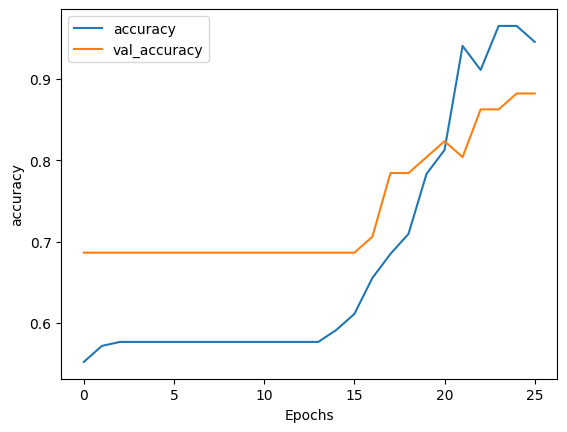

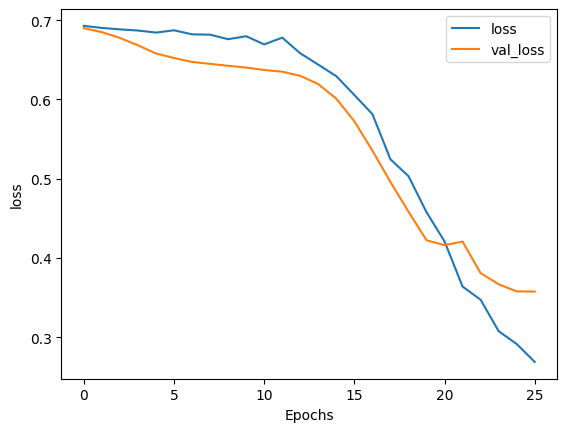

In [223]:
# Plot the accuracy and loss history
plot_graphs(history_lstm, 'accuracy')
plot_graphs(history_lstm, 'loss')

In [224]:
# Get the embedding layer from the model (i.e. first layer)
embedding_layer = model_lstm.layers[0]

# Get the weights of the embedding layer
embedding_weights = embedding_layer.get_weights()[0]

# Print the shape. Expected is (vocab_size, embedding_dim)
print(embedding_weights.shape) 

reverse_word_index = {i: token for i, token in enumerate(BPE_sentence_tokenizer.get_vocab())}
print(reverse_word_index)
print(len(reverse_word_index))

# Get the index-word dictionary


(10000, 8)
{0: '▁turn', 1: '▁depth', 2: '▁micha', 3: '▁review', 4: '>', 5: 'fore', 6: '▁brend', 7: '▁ios\r\n', 8: "▁couldn't", 9: 'í', 10: '▁called', 11: '▁x', 12: '▁sorry', 13: '▁po', 14: '▁block', 15: '▁view', 16: 'ty', 17: 'mouth', 18: '▁amazed', 19: 'bur', 20: '▁full', 21: '▁something', 22: 'ny', 23: '▁who’s', 24: 'el', 25: '▁notch', 26: '▁worker', 27: '▁upset', 28: '▁ser', 29: '▁hey', 30: 'ctice', 31: '▁forever', 32: '▁doesn’t', 33: '41', 34: '▁god', 35: '▁قَ', 36: '▁atta', 37: '▁shows', 38: '11', 39: '▁quickly', 40: 'cle', 41: 'it', 42: '▁quick', 43: '▁aol', 44: 'ck', 45: 'ris', 46: '▁wants', 47: '▁wonder', 48: '▁brothers', 49: '▁regarding', 50: '▁st', 51: 'm', 52: 'd', 53: '▁sp', 54: '▁ref', 55: 'ap', 56: '▁fantastic', 57: 'ope', 58: '▁what', 59: 'ke', 60: 'ice:', 61: '▁you', 62: 'om', 63: 'ع', 64: 'mon', 65: 'rough', 66: '▁away', 67: '▁yest', 68: '▁effort', 69: '▁can', 70: '▁covid', 71: '▁has', 72: "n't", 73: '▁replacement', 74: 'ates', 75: 'mail', 76: 'side', 77: 'ctly', 78: '

Cell below was used for visual analysis of tokenized subwords

In [192]:
import io

# Open writeable files
out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')

# Initialize the loop. Start counting at `1` because `0` is just for the padding
for word_num in range(1, vocab_size):

  # Get the word associated at the current index
  word_name = reverse_word_index[word_num]

  # Get the embedding weights associated with the current index
  word_embedding = embedding_weights[word_num]

  # Write the word name
  out_m.write(word_name + "\n")

  # Write the word embedding
  out_v.write('\t'.join([str(x) for x in word_embedding]) + "\n")

# Close the files
out_v.close()
out_m.close()

KeyError: 2242

A little testing with tf tokenizer

In [193]:
seed_text = "Super Good and i like it"
token_list = tokenizer.texts_to_sequences([seed_text])[0]
token_list = pad_sequences([token_list], padding='pre')
print(token_list)
# Feed to the model and get the probabilities for each index
probabilities = model_lstm.predict(token_list, verbose=0)
# Get the index with the highest probability
predicted = np.argmax(probabilities, axis=-2)
print(probabilities)
if probabilities[0][0]>0.5:
    print("1")
else:
    print("0")

AttributeError: 'BertTokenizer' object has no attribute 'texts_to_sequences'

Testing with custom tokenizer

In [225]:
input_sentence = "My boyfriend bought me flowers today. They were very beautiful, but I had to spend the whole day outside. When I came home, they were already flabby. So I don’t like the quality of flowers in that shop."

# Preprocess the sentence (lowercase, tokenize, and pad)
input_sequence = BPE_sentence_tokenizer.encode(input_sentence).ids
input_sequence = pad_sequences([input_sequence], maxlen=max_length_num, padding='pre')

# Make a prediction
predicted_probability = model_lstm.predict(input_sequence)

# Interpret the prediction (assuming binary classification)
if predicted_probability > 0.5:
    sentiment = "positive"
else:
    sentiment = "negative"

print(f"Predicted Sentiment: {sentiment} (Probability: {predicted_probability[0][0]})")



1/1 [==============================] - 1s 562ms/step
Predicted Sentiment: negative (Probability: 0.443075031042099)


In [226]:
# Assuming you have trained your model and stored it in the `model_lstm` variable
# Specify the path where you want to save the model
model_save_path = './my_trained_model'

# Save the model
model_lstm.save(model_save_path)



INFO:tensorflow:Assets written to: ./my_trained_model\assets


INFO:tensorflow:Assets written to: ./my_trained_model\assets


In [131]:
from transformers import BertTokenizerFast

new_tokenizer = BertTokenizerFast(tokenizer_object=BPE_sentence_tokenizer)
new_tokenizer.save_pretrained('./my_tokenizer')


('./my_tokenizer\\tokenizer_config.json',
 './my_tokenizer\\special_tokens_map.json',
 './my_tokenizer\\vocab.json',
 './my_tokenizer\\merges.txt',
 './my_tokenizer\\added_tokens.json',
 './my_tokenizer\\tokenizer.json')